In [76]:
%matplotlib inline
import networkx as nx
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import time
import pickle
from collections import OrderedDict, deque, defaultdict
from nervenet import NerveNet_GNN
from copy import deepcopy
import random

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

In [52]:
# Note: when you see a loss of nan in the prints its okay, if the num of steps is less than the freq of training

In [53]:
# https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861/2

# List of things todo
- ~~Add Double DQN and make sure vanilla DQN formula is correct~~
- ~~Need to track the grads and detach the grads for outputs that arent a part of the actual minibatch fit~~
- ~~Debug multiple props~~
- ~~Track the grad for multiple props~~
- ~~Go through "https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"~~
- ~~After going through ^ see if i need to change my loss because i think that I need to reshape or something so that the vector is summed and then meaned which means that the mean does nothing since there is only one sample per train anyway~~
- ~~Also make sure to add huber loss~~
- ~~Add dikstras to get optimal path from init to goal and use this both as reward and to limit the the path length in an ep~~
- check if adding cuda actually made it slower
- ~~Getting a loss of nan sometimes after running it for a while, see whats up~~
- setup a framework/csv to keep track of all hyperparams when im tuning, even remember things that arent constants such as what feats i use for a node etc.
    - Might also want to add time data for certain parts of the code
- add soft updates for target model
- Try adding the link encodings to each node feature cuz right now i just use title
- Try adding priotirzied exp replay or at least weights based on if its a terminal tuple
- Try instead of looping through for each prop, expliclty unrolling each prop to make sure that replacing the var node states isnt an issue
- See if i need node feats and goal feats to have grad
- Add in ignore intenral nodes and see if that improves performance

## Grab data and make Graph

In [54]:
class Page:
    def __init__(self, text, links):
        self.text = text
        self.links = links  # out-links
        self.in_links = []
        self.indx = None  # Relative to the ordered dict below
        self.feats = None

In [55]:
# Load the wiki-dict i want
with open('data/animals-D3-small-30K-nodes40-edges202-max10-minout2-minin3_w_features.pkl', 'rb') as f:
    pages = pickle.load(f)

In [56]:
# Convert to ordered dict so i can use indices to refer to pages
# Convert pages to ordered dict
pages = OrderedDict(pages)
# Add indices and get feats for each page
node_feats = []
for indx, (title, obj) in enumerate(pages.items()):
    obj.indx = indx
    node_feats.append(obj.feats)
node_feats = np.stack(node_feats)

In [57]:
# Make edges for graph generation
edges = []
for title, obj in pages.items():
    for link in obj.links:
        in_node = obj.indx
        out_node = pages[link].indx
        edges.append((in_node, out_node))

In [58]:
# Make whole graph
G_whole = nx.DiGraph()
G_whole.add_edges_from(edges)

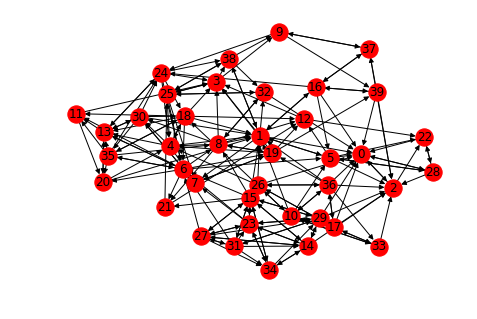

In [59]:
nx.draw_kamada_kawai(G_whole, with_labels=True)
plt.show()

### Constants

In [77]:
# Episode Constants
episode_C = {}
episode_C['train_num_eps'] = 200
episode_C['test_num_steps'] = 50
episode_C['max_ep_steps'] = 10
episode_C['ignore_internal_nodes'] = False
episode_C['num_props'] = 1
# optimal num of actions of an ep is the shortest path from init to goal minus one
episode_C['shortest_path_range_allowed_MIN'] = 4  # in number of edges between init node and goal node
episode_C['shortest_path_range_allowed_MAX'] = 6

In [78]:
# Data/Model Constants
model_C = {}
model_C['num_nodes'] = len(pages)
model_C['num_edges'] = len(edges)
model_C['node_feat_size'] = node_feats.shape[1]
model_C['edge_feat_size'] = None
model_C['node_hidden_size'] = 32
model_C['edge_hidden_size'] = None
model_C['message_size'] = 32
model_C['output_size'] = 1

In [79]:
# Goal Constants
# there are two ways im testing, 
# 1)if i put it in the state update func
# 2) if I send it in to the output i.e. after the update 
goal_C = {}
goal_C['goal_opt'] = 2
# Another option is whether to put the goal through the input layer or not
goal_C['goal_input_layer'] = True
if goal_input_layer:
    goal_size = node_hidden_size
else:
    goal_size = node_feat_size
goal_C['goal_size'] = goal_size

In [80]:
# Agent Constans
agent_C = {}
agent_C['num_warmup_steps'] = 500
agent_C['mem_max_size'] = 100000
agent_C['init_eps'] = 1.0
agent_C['final_eps'] = 0.05
agent_C['final_exp_step'] = 5000
agent_C['target_update_freq'] = 50
agent_C['train_freq'] = 50
agent_C['train_freq'] = 4
agent_C['double_dqn'] = True
agent_C['minibatch_size'] = 32
agent_C['gamma'] = 0.99
agent_C['learning_rate'] = 1e-3
agent_C['clip_grads'] = True
agent_C['grad_clamp_val'] = 1

In [82]:
# Other Constants
other_C = {}
other_C['reach_goal_rew'] = 10
other_C['not_reach_goal_rew'] = -5

In [64]:
# For seeing how long paths tend to be in a graph

# arr = []
# for _ in range(200):
#     init_node = random.randint(0, num_nodes-1)
#     goal_node = random.randint(0, num_nodes-1)
#     if not nx.has_path(G_whole, init_node, goal_node) or init_node == goal_node:
#         continue
#     shortest_path_length = nx.shortest_path_length(G_whole, init_node, goal_node)
#     if shortest_path_length == 1:
#         continue
#     arr.append(shortest_path_length)
# np.array(arr).mean()

## DQN Agent

In [65]:
def cos_sim(a, b):
    return cosine_similarity(a, b)[:, 0]

In [66]:
# For now this is -1 per timestep +5 on terminal for reaching goal, -5 on terminal for not reaching goal
# And when it reaches the goal, give add (shortest_path_length - 1) - num actions taken (neg number)
def reward_func(terminal, reach_goal, shortest_path_length, num_actions_taken):
    rew = -1
    if terminal:
        if reach_goal:
            assert num_actions_taken >= (shortest_path_length-1)
            rew += other_C['reach_goal_rew']
            rew += ((shortest_path_length-1) - num_actions_taken)  # optimal num actions - num actions taken
        else:
            rew += other_C['not_reach_goal_rew']
    return rew

In [67]:
class DQNAgent:
    def __init__(self):
        self.memory  = deque(maxlen=mem_max_size)
        self.eps = init_eps
        # Make behavior gnn and target gnn
        self.gnn = NerveNet_GNN(node_feat_size, node_hidden_size, message_size, output_size, goal_size, goal_opt, device).to(device)
        self.gnn_ = NerveNet_GNN(node_feat_size, node_hidden_size, message_size, output_size, goal_size, goal_opt, device).to(device)
        self.update_target_models()
        self.optimizer = optim.Adam(self.gnn.parameters(), lr=learning_rate)

    # train_step is overall train step (not just per ep)
    def update_implicit_policy(self, train_step):
        if train_step <= final_exp_step:
            self.eps = final_eps + (init_eps - final_eps) * np.maximum(0, (final_exp_step - train_step)) / final_exp_step
    
    def remember(self, mem_tuple):
        self.memory.append(mem_tuple)

    # act (eps-greedy)
    def select_node(self, outputs, warmup=False):
        # Explore
        if random.random() < self.eps or warmup:
            action = random.randint(0, outputs.shape[0]-1)
        else:
            action = outputs.argmax()
        return action
    
    # TODO: See if soft-update improves performance
    def update_target_models(self):
        self.gnn_.load_state_dict(self.gnn.state_dict())
    
    # DEBUG -----------
    def print_memory(self):
        for mem in self.memory:
            state, action, reward, next_state, done = mem[0], mem[1], mem[2], mem[3], mem[4]
            print('State::')
            print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(state['num_nodes'], state['goal_feats'], state['G_curr'].nodes, state['current_nodes']))
            
            print('Action::'+str(action))
            
            print('Reward::'+str(reward))
            
            print('Next State::')
            print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(next_state['num_nodes'], next_state['goal_feats'], next_state['G_curr'].nodes, next_state['current_nodes']))
            
    # ------------------
    
    # TODO: Figure out how to optimize this and _fit to run multiple graphs/states at once
    def train(self):
        # Sample a minibatch of memory tuples
        minibatch = random.sample(self.memory, minibatch_size)
        output_vals, expected_vals = [], []
        
        for state, action, reward, next_state, done in minibatch:
            with torch.no_grad():
                target = reward
                if not done:
                    if not double_dqn:
                        outputs = propogate(self.gnn_, next_state).detach().cpu().numpy()  # Detach grad
                        target = reward + gamma * outputs.max()
                    else:
                        outputs_beh = propogate(self.gnn, next_state).detach().cpu().numpy()
                        next_state_action = np.argmax(outputs_beh)
                        outputs_tar = propogate(self.gnn_, next_state).detach().cpu().numpy()
                        outputs_tar_action_val = outputs_tar[next_state_action]
                        target = reward + gamma * outputs_tar_action_val
            
            # Run state through behavior model (NEEDS GRAD)
            state_action_output = propogate(self.gnn, state)
            state_action_output_val = state_action_output[action]
            output_vals.append(state_action_output_val)
            
            # Add Target
            expected_vals.append(target)
            
        # Stack 
        output_stack = torch.stack(output_vals).unsqueeze(1)
        expected_stack = np.stack(expected_vals).reshape(-1, 1)
        expected_stack = torch.tensor(expected_stack, dtype=torch.float, device=device)
        assert output_stack.shape == (minibatch_size, 1), output_stack.shape
        assert output_stack.shape == expected_stack.shape, expected_stack.shape
        assert output_stack.requires_grad == True
        assert expected_stack.requires_grad == False
        
        # Backprop
        self.optimizer.zero_grad()
        loss = self.gnn.backward(output_stack, expected_stack)
        if clip_grads:
            for param in self.gnn.parameters():
                param.grad.data.clamp_(-grad_clamp_val, grad_clamp_val)
        self.optimizer.step()
#         print('loss: {}'.format(loss))
        return loss

## Run It

In [68]:
# node_indx is the same indx as G_curr and G_whole
def add_children(G_curr, node_indx, goal_node_indx, current_nodes):
    achieved_goal = False
    # Check the children of the node to see if they need to be added to the current graph
    children = G_whole.successors(node_indx)
    for child in children:
        # Add child if not in G and check if goal
        if child not in G_curr:
            G_curr.add_node(child)
            current_nodes.update({child: len(current_nodes)})
            if child == goal_node_indx:
                achieved_goal = True
        # If the edge doesnt exist add it
        if not G_curr.has_edge(node_indx, child):
            G_curr.add_edge(node_indx, child)
    assert sorted(list(current_nodes.values())) == list(current_nodes.values())
    return achieved_goal

In [69]:
def initialize_ep():
    current_try = 0
    while True:
        current_try += 1
#         if current_try >= 50:
#              print('Current try for initialize ep is at: {}'.format(current_try))
        init_node = random.randint(0, num_nodes-1)
        goal_node = random.randint(0, num_nodes-1)
        # restart if goal node is init node, or no path
        if init_node == goal_node or not nx.has_path(G_whole, init_node, goal_node):
            continue
        # restart if shortest path is too long or too short
        shortest_path = nx.shortest_path_length(G_whole, init_node, goal_node)
        if shortest_path < shortest_path_range_allowed[0] or shortest_path > shortest_path_range_allowed[1]:
            continue
        break
        
    # Get goal feats
    goal_feats = node_feats[goal_node]
    assert goal_feats.shape == (node_feat_size,)
    # Make init graph
    G_init = nx.DiGraph()
    G_init.add_node(init_node)
    current_nodes = OrderedDict({init_node: 0})  # Init current nodes dict
    got_goal = add_children(G_init, init_node, goal_node, current_nodes)
    assert sorted(list(current_nodes.values())) == list(current_nodes.values())
    assert not got_goal
    
    return G_init, current_nodes, goal_node, goal_feats, shortest_path

In [70]:
# current_nodes: ordereddict with keys as abs node indices, values as rel node indices (rel to the ordered dict)
def get_predecessors(G_curr, current_nodes):
    all_preds = []  # List of lists
    for node in current_nodes.keys():
        preds_abs = G_curr.predecessors(node)  # abs to all nodes, keys to the dict
        preds_rel = [current_nodes[x] for x in preds_abs]
        all_preds.append(preds_rel)
    return all_preds  # Returns a list of lists with the values being tth rel node indices

In [71]:
def propogate(gnn, state):
    num_nodes, goal_feats, G_curr, current_nodes = state['num_nodes'], state['goal_feats'], state['G_curr'], state['current_nodes']
    node_feats_tensor = torch.tensor(node_feats, device=device, requires_grad=True, dtype=torch.float)
    goal_feats_tensor = torch.tensor(goal_feats, device=device, requires_grad=True, dtype=torch.float)
    # Grab the feats of the nodes in the current graph
    node_states = node_feats_tensor[list(current_nodes.keys())] 
    # If goal_input_layer is True then embed the goal by sending it into the input layer
    if goal_input_layer:
        goal_embeddings = gnn.input_model(goal_feats_tensor.reshape(1, -1)).flatten()
        stacked_goal_embeds = torch.stack([goal_embeddings] * num_nodes)
    else:
        stacked_goal_embeds = torch.stack([goal_feats_tensor] * num_nodes)
    for p in range(num_props):
        predecessors = get_predecessors(G_curr, current_nodes)
        node_states, outputs = gnn(node_states, p == 0, p == num_props-1, predecessors, stacked_goal_embeds)
        assert node_states.shape == (num_nodes, node_hidden_size)
    assert outputs.flatten().shape == (num_nodes,)
    return outputs.flatten()

In [72]:
# Deep copy everything before it goes into a state
def make_state(current_nodes, goal_feats, G_curr):
    current_nodes_copy = current_nodes.copy()
    goal_feats_copy = goal_feats
    G_curr_copy = G_curr.copy()
    return {'num_nodes': len(current_nodes_copy), 'goal_feats': goal_feats_copy, 'G_curr': G_curr_copy, 'current_nodes': current_nodes_copy}

In [73]:
# Just to fill memory of agent, no training
def warmup_episode(total_step):
    G_curr, current_nodes, goal_node, goal_feats, shortest_path_length = initialize_ep()
    assert len(current_nodes) > 1
    ep_rew = 0
    state = make_state(current_nodes, goal_feats, G_curr)
    for step in range(max_ep_steps):
        with torch.no_grad():
            outputs = propogate(agent.gnn, state).detach().cpu().numpy()
        selected_node_rel = agent.select_node(outputs, warmup=True)
        selected_node_abs = list(current_nodes.keys())[selected_node_rel]
        
        state = deepcopy(state)
        
        achieved_goal = add_children(G_curr, selected_node_abs, goal_node, current_nodes)
        done = True if (step == max_ep_steps - 1) or achieved_goal or total_step == num_warmup_steps else False
        rew = reward_func(done, achieved_goal, shortest_path_length, step+1)
        ep_rew += rew
        
        next_state = make_state(current_nodes, goal_feats, G_curr)
        memory_tuple = (state, selected_node_rel, rew, next_state, done)
        agent.remember(memory_tuple)
        
        state = deepcopy(next_state)
        
        total_step += 1
        if done:
            break
            
#     print('Episode {}  Mem. size: {}  Reward: {}  Achieved goal: {}  Optimal num steps: {}  Taken num steps: {}'.format(ep+1, len(agent.memory), ep_rew, achieved_goal, shortest_path_length-1,step+1))
    
    return total_step, ep_rew, achieved_goal, shortest_path_length-1, step+1

In [74]:
def train_episode(ep, total_step):
    # Init. the episode graph and current nodes
    G_curr, current_nodes, goal_node, goal_feats, shortest_path_length = initialize_ep()
    assert len(current_nodes) > 1
    ep_rew = 0
    ep_losses = []
    ep_history = [G_curr.copy()]  # Save the graphs
    state = make_state(current_nodes, goal_feats, G_curr)
    for step in range(max_ep_steps):

        # Pick node to explore by propogating -- Take Action --
        with torch.no_grad():
            outputs = propogate(agent.gnn, state).detach().cpu().numpy()
        selected_node_rel = agent.select_node(outputs)
        selected_node_abs = list(current_nodes.keys())[selected_node_rel]

        state = deepcopy(state)

        # Add the children -- Run env forward a step --
        achieved_goal = add_children(G_curr, selected_node_abs, goal_node, current_nodes)
        ep_history.append(G_curr.copy())
        # Done if goal found or end of ep
        done = True if (step == max_ep_steps - 1) or achieved_goal else False
        rew = reward_func(done, achieved_goal, shortest_path_length, step+1)
        ep_rew += rew

        # Add to agent memory pool
        next_state = make_state(current_nodes, goal_feats, G_curr)
        
        memory_tuple = (state, selected_node_rel, rew, next_state, done)
        agent.remember(memory_tuple)
        state = deepcopy(next_state)
        
        # Update eps-greedy policy
        agent.update_implicit_policy(total_step)
        
        # Update target model if necc
        if total_step % target_update_freq == 0 and total_step != 0:
            agent.update_target_models()
            
        # Train if necc
        if total_step % train_freq == 0 and total_step != 0 and len(agent.memory) >= minibatch_size:
            mb_loss = agent.train()
            ep_losses.append(mb_loss)
        
        total_step += 1
        if done:
            break

    print('Episode {}  Epsilon: {:2f}  Mem. size: {}  Avg loss: {:3f}  Reward: {}  Achieved goal: {}  Optimal num steps: {}  Taken num steps: {}'.format(ep+1, agent.eps, len(agent.memory), np.array(ep_losses).mean(), ep_rew, achieved_goal, shortest_path_length-1,step+1))
    
    return total_step, ep_history, np.array(ep_losses).mean(), ep_rew

    

In [84]:
def run(episode_C, model_C, goal_C, agent_C, other_C):
    agent = DQNAgent()

    print('\n---------- Warmup initiated ----------\n')
    warmup_step = 0
    warmup_ep = 0
    warmup_info = defaultdict(list)
    while warmup_step < num_warmup_steps:
        warmup_step, ep_rew, achieved_goal, opt_steps, steps_taken = warmup_episode(warmup_step)
        warmup_ep += 1
        warmup_info['episode reward'].append(ep_rew)
        warmup_info['achieved goal'].append(achieved_goal)
        warmup_info['opt steps'].append(opt_steps)
        warmup_info['steps taken'].append(steps_taken)
    print('Warmup stage summary:  Memory size: {}  Avg ep rew: {:.2f}  Achieved goal ratio: {:.2f}  Avg opt num steps: {:.2f}  Avg num steps taken: {:.2f}'.format(len(agent.memory),
                                                                                                                                 np.array(warmup_info['episode reward']).mean(),
                                                                                                                                 np.array(warmup_info['achieved goal']).sum() / warmup_ep,
                                                                                                                                 np.array(warmup_info['opt steps']).mean(),
                                                                                                                                 np.array(warmup_info['steps taken']).mean()))

    print('\n---------- Training initiated ----------\n')
    train_step = 0
    train_info = {}
    train_info['max ep rew'] = float('-inf')
    train_info['episode of best reward'] = 0
    train_info['min ep loss'] = float('inf')
    train_info['episode of best loss'] = 0
    history = []
    for ep in range(train_num_eps):
        train_step, ep_history, loss, ep_rew = train_episode(ep, train_step)
    #     history.append(ep_history)
        train_info['max ep rew'] = max(train_info['max ep rew'], ep_rew)
        if train_info['max ep rew'] == ep_rew:
            train_info['episode of best reward'] = ep+1 
        train_info['min ep loss'] = min(train_info['min ep loss'], loss)
        if train_info['min ep loss'] == loss:
            train_info['episode of best loss'] = ep+1 
    print('\nTraining summary:  Max episode reward: {} at episode {},  Min episode loss: {:.3f} at episode {}'.format(train_info['max ep rew'], 
                                                                                                                          train_info['episode of best reward'], 
                                                                                                                          train_info['min ep loss'], 
                                                                                                                          train_info['episode of best loss']))                                                                                   

    plt.show()

    print('\n---------- Testing initiated ----------\n')
    test_step = 0
    test_info = {}
    test_info['all ep rew'] = []
    test_info['max ep rew'] = float('-inf')
    test_info['min ep rew'] = float('inf')
    test_info['achieved goal'] = []
    test_info['opt steps'] = []
    test_info['steps taken'] = []
    for ep in range(test_num_eps):
        test_step, ep_rew, achieved_goal, opt_steps, steps_taken = test_episode(test_step)
        test_info['all ep rew'].append(ep_rew)
        test_info['max ep rew'] = max(test_info['max ep rew'], ep_rew)
        test_info['min ep rew'] = min(test_info['min ep rew'], ep_rew)
        test_info['achieved goal'].append(achieved_goal)
        test_info['opt steps'].append(opt_steps)
        test_info['steps taken'].append(steps_taken)
    print('\nTesting summary: Avg ep rew: {:2f}  Max ep rew: {}  Min ep rew: {}  Achieved goal percent: {:.2f}  Avg opt steps: {:.2f}  Avg steps taken: {:.2f}'.format(
                                                    np.array(test_info['max ep rew']).mean(),
                                                    test_info['max ep rew'],
                                                    test_info['min ep rew'],
                                                    np.aray(test_info['achieved goal']).sum() / ep,
                                                    np.array(test_info['opt steps']).mean(),
                                                    np.array(test_info['steps taken']).mean()
                                                      ))
    
    # Return all info that is appended to the df of experiments (make a dict)
    run_info = {}
    def add_hyp_param_dict(append_letter, dic):
        for k, v in list(dic.items()):
            run_info[append_letter + k] = v
    add_hyp_param_dict(episode_C)
    add_hyp_param_dict(model_C)
    add_hyp_param_dict(goal_C)
    add_hyp_param_dict(agent_C)
    add_hyp_param_dict(other_C)
    run_info[]
    
    

In [85]:
def select_hyp_params(grid):
    episode_C, model_C, goal_C, agent_C, other_C  = {}, {}, {}, {}, {}
    def select_params(dic):
        return_dic = {}
        for name, values in list(dic.items()):
            return_dic[name] = random.sample(values)
        return return_dic
    episode_C = select_params(grid['episode_C'])
    model_C = select_params(grid['model_C'])
    goal_C = select_params(grid['goal_C'])
    agent_C = select_params(grid['agent_C'])
    other_C = select_params(grid['other_C'])
    return episode_C, model_C, goal_C, agent_C, other_C


---------- Warmup initiated ----------

Warmup stage summary:  Memory size: 501  Avg ep rew: -13.33  Achieved goal ratio: 0.13  Avg opt num steps: 3.44  Avg num steps taken: 9.63

---------- Training initiated ----------



C:\Users\Max Brenner\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Users\Max Brenner\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Episode 1  Epsilon: 0.998290  Mem. size: 511  Avg loss: 1.016675  Reward: -15  Achieved goal: False  Optimal num steps: 3  Taken num steps: 10
Episode 2  Epsilon: 0.996390  Mem. size: 521  Avg loss: 1.158143  Reward: -15  Achieved goal: False  Optimal num steps: 3  Taken num steps: 10
Episode 3  Epsilon: 0.994490  Mem. size: 531  Avg loss: 1.147954  Reward: -15  Achieved goal: False  Optimal num steps: 3  Taken num steps: 10
Episode 4  Epsilon: 0.992590  Mem. size: 541  Avg loss: 0.785166  Reward: -15  Achieved goal: False  Optimal num steps: 5  Taken num steps: 10
Episode 5  Epsilon: 0.990880  Mem. size: 550  Avg loss: 0.973379  Reward: -5  Achieved goal: True  Optimal num steps: 3  Taken num steps: 9
Episode 6  Epsilon: 0.988980  Mem. size: 560  Avg loss: 0.853399  Reward: -7  Achieved goal: True  Optimal num steps: 3  Taken num steps: 10
Episode 7  Epsilon: 0.987080  Mem. size: 570  Avg loss: 0.747827  Reward: -15  Achieved goal: False  Optimal num steps: 3  Taken num steps: 10
Epis

KeyboardInterrupt: 

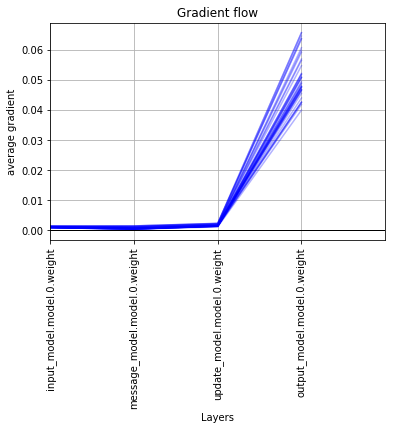

In [75]:
def run_random_search(num_experiments, grid, df):
    for experiment in range(num_experiments):
        print('Running experiment {}'.format(experiment))
        
        # First pick the hyp params to use
        episode_C, model_C, goal_C, agent_C, other_C = select_hyp_params(grid)
        
        run_info = run(episode_C, model_C, goal_C, agent_C, other_C)
        
        # Add to df
        df.append(run_info)
        

In [ ]:
episode_C_grid = {
    
}
model_C_grid = {
    
}
goal_C_grid = {
    
}
agent_C_grid = {
    
}
other_C_grid = {
    
}
grid = ['episode_C': episode_C_grid,
       'model_C': model_C_grid,
       'goal_C': goal_C_grid,
       'agent_C': agent_C_grid,
       'other_C': other_C_grid

run_random_search(50, grid, ...)

In [ ]:
# Vis. an episodes graphs
def vis_ep(ep_graphs):
    for G in ep_graphs:
        nx.draw_kamada_kawai(G, with_labels=True)
        plt.show()
# vis_ep(history[-1])